# Clustering

## Based on the article [PATS](http://ismir2002.ircam.fr/proceedings/OKPROC02-FP07-4.pdf)

The ideia is to establish a similarity metric and do a clusterization process with these metrics. 

In [1]:
# Importing libraries 
import pandas as pd 
import numpy as np 

from sklearn.cluster import AffinityPropagation, SpectralClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

from seaborn import heatmap 
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob
import os
import time

## Defining Important Features 

This features will be used to understand the data. 

In [4]:
metadata =  ['playlist_id', 'duration_ms', 'explicit', 'id', 'album_type', 'popularity', 'album_id', 
             'album_release_date', 'artists_ids', 'name', 'artists_names']
audio_features = ['danceability', 'energy', 'loudness', 'key', 'mode', 'speechiness', 'acousticness', 
                  'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'id']

## Playlist and tracks dataframes 

Getting the data generated by Spotify API. 

In [5]:
playlists_df = pd.read_pickle('../data/sp_playlists.pkl')[['id']]
playlists_df['playlist_id'] = playlists_df['id']
playlists_df = playlists_df[['playlist_id']]
audio_features_df = pd.read_pickle('../data/sp_audio_features.pkl')[audio_features]
tracks_df = pd.concat(
    [pd.read_pickle(file)[metadata] for file in glob.glob('../data/sp_tracks_ready_*.pkl')],
    ignore_index=True
)

In [6]:
tracks_df = audio_features_df.merge(tracks_df, on = 'id')
tracks_df = tracks_df.merge(playlists_df, on = 'playlist_id')

In [7]:
del audio_features 
del playlists_df 

I convert the dates to datetime and use the year as a continuum value. 

In [8]:
tracks_df['album_release_date'] = tracks_df['album_release_date'].apply(lambda x: 
                                                                        None if x == '0000' else pd.to_datetime(x))
tracks_df['years'] = tracks_df['album_release_date'].apply(lambda x: x.year + x.month/12 + x.day/365)
tracks_df.set_index('id', inplace = True)
tracks_df.sample()

,danceability,energy,loudness,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,duration_ms,explicit,album_type,popularity,album_id,album_release_date,artists_ids,name,artists_names,years
id,,,,,,,,,,,,,,,,,,,,,
1KGrtfKP2Gg93XN6Y5o9E0,0.659,0.857,-4.776,11,0,0.0402,0.0255,0.279,0.113,0.127,...,178686.0,False,single,51.0,5zDDdGkqSUEUK0HZHKeUaQ,2020-02-14,"[0YAmYesPdjvMPgnLKcDHR3, 4H1rPQHJFk09XbKGYszUe...",Imensidão,"[Skazi, Beowülf, Samantha Machado]",2020.205023


I separate the catefortical, numerical and set_oriented features, to make the ideia of the similarity matrix. 

In [9]:
features_categorical =  ['explicit', 'album_type', 'album_id', 'key', 'mode', 'time_signature']
features_numerical = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'years']
features_set_oriented = ['artists_ids']

features = [] 
features.extend(features_categorical)
features.extend(features_numerical)
features.extend(features_set_oriented)

Only to ensure correct type here.

In [10]:
tracks_df[features_numerical] = tracks_df[features_numerical].astype(float)

Let's build the metrics proposed. For now, I normalize the numerical data, ensuring the range to be $[0,1]$. 

In [11]:
scaler = MinMaxScaler()
tracks_df[features_numerical] = scaler.fit_transform(tracks_df[features_numerical])

In [12]:
metric_categorical = lambda x1,x2: x1 == x2
metric_set_oriented = lambda x1, x2: len(set(x1) & set(x2))/(max(len(x1), len(x2)))
metric_numerical = lambda x1, x2: 1 - abs(x1 - x2)

def metric_songs(x: np.array, y: np.array) -> float: 
    # Arbitrary choice 
    weight = np.ones(19)/19
    
    similarity = 0
    similarity += sum(weight[0:6]*metric_categorical(x[0:6], y[0:6]))
    similarity += sum(weight[6:18]*metric_numerical(x[6:18], y[6:18]))
    similarity += weight[18]*metric_set_oriented(x[18], y[18])

    return similarity

## Simple example :


A matriz de similaridade agora é de distâncias depois da transformação. 

In [17]:
x1 = np.array(tracks_df[features].iloc[9])
x2 = np.array(tracks_df[features].iloc[240])
metric_songs(x1, x2)

0.6775033072061212

## Calculate the Similarity Matrix

I use the pdist function to calculate distance between tracks. I sample only 2 thousand song, because it can take a long time to run the comparision between all songs. After I can convert this similarity matrix to a distance matrix if I wish. 

In [18]:
tracks_selected = tracks_df.sample(2000, random_state = 1000)
tracks_similarity = pdist(tracks_selected[features].values, metric = metric_songs)

In [19]:
# tracks_similarity = - lambda*np.log(lambda*tracks_similarity)
tracks_similarity = squareform(tracks_similarity) + np.eye(2000)

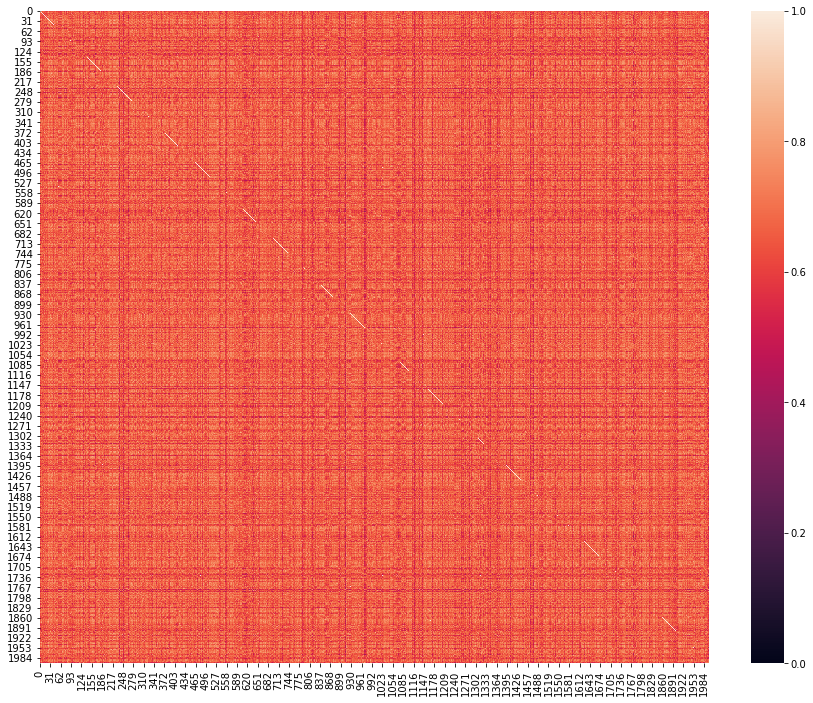

In [97]:
fig, ax = plt.subplots(figsize = (15,12))
heatmap(tracks_similarity, vmin = 0, vmax = tracks_similarity.max(), ax = ax)

plt.show()

## Clusterization Algorithms

This algorithms require distance matrix. 

In [195]:
model = AffinityPropagation(affinity = 'precomputed').fit(tracks_similarity)

Quantos labels foram feitos? 

In [199]:
len(np.unique(model.labels_))

13

Quantas playlists realmente existiam?

In [200]:
len(tracks.iloc[0:2000].playlist_id.unique())

27

In [214]:
model2 = DBSCAN(eps = 0.25, metric = 'precomputed').fit(tracks_similarity)

In [215]:
len(model2.labels_[model2.labels_ == -1])

114

In [217]:
len(np.unique(model2.labels_))

15

In [218]:
model3 = SpectralClustering(n_clusters=27, affinity='precomputed').fit(tracks_similarity)

## Recommendation based on similarity. 

In [42]:
number_of_songs = 15 

def get_similar_track(indexes: list, tracks_similarity: np.array) -> int: 
    
    tracks_similarity = tracks_similarity - np.eye(len(tracks_similarity))
    
    interest_tracks = tracks_similarity[indexes,].prod(axis = 0)
    song = np.argmax(interest_tracks)
    
    return song 

def get_playlist(number_of_songs: int, tracks_similarity: np.array, initial_song: int) -> list: 
    
    assert initial_song < len(tracks_similarity)
    assert initial_song >= 0 
    
    songs = [initial_song]
    for i in range(number_of_songs):
        songs.append(get_similar_track(songs, tracks_similarity))
        
    return songs

In [43]:
initial_song = np.random.randint(0,2000)
playlist = get_playlist(number_of_songs, tracks_similarity, initial_song)

In [46]:
tracks_selected.iloc[playlist]

,danceability,energy,loudness,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,duration_ms,explicit,album_type,popularity,album_id,album_release_date,artists_ids,name,artists_names,years
id,,,,,,,,,,,,,,,,,,,,,
74muMkVdMYoR65lhmdzy13,0.649547,0.884,0.878390,1,1,0.099691,0.112450,0.000000,0.1790,0.708,...,0.016567,False,album,0.45,6YL9J0E6PGtYzkhyMxnmXd,2015-09-09,[1z4g3DjTBBZKhvAroFlhOM],Day 1,[Red Velvet],0.960664
37xmYCdS1pNz8TRFoaKvrR,0.649547,0.821,0.859517,1,1,0.157570,0.016064,0.000012,0.1560,0.661,...,0.016776,False,album,0.58,5q4CMxHUBPn11UG6uYX26m,2013-04-19,"[4RxUeUyMaEe2T5tvULq5j0, 5Ayl2bJtN5mdCsxZoxs9n1]",Smoke the Weed (feat. Collie Buddz),"[Snoop Lion, Collie Buddz]",0.942966
3oZUlZMXkj51AyYG8lGaE7,0.593152,0.797,0.856706,1,1,0.178167,0.000676,0.000000,0.0246,0.787,...,0.013530,False,album,0.59,4fIVLcTjPnagYnDmTivhiY,2005-01-01,[5R5MLOQbI4lb7GHYioPqoN],Shut Me Up,[Mindless Self Indulgence],0.881489
2OxcH2hvo4SrVGO3gd7RJO,0.636455,0.819,0.830615,1,1,0.160659,0.032129,0.009400,0.0473,0.454,...,0.018501,False,album,0.44,0q1YbH7gLkklLFxNBLRKHD,2004-03-22,[1xU878Z1QtBldR7ru9owdU],Run Run Run,[Phoenix],0.875742
2Ll0eOXFmIeBlcybOSaQJm,0.503525,0.833,0.836251,1,1,0.041607,0.009618,0.000000,0.1670,0.451,...,0.017220,False,album,0.56,5AtTKLErRJPLZAOfPabe7m,2018-08-24,[6kNKUYGn6VNGsRoXmyoDPK],Ivy (Doomsday),[The Amity Affliction],0.982574
1FFpE97M77Nf8HxF8SDJZJ,0.414904,0.952,0.883120,1,1,0.214212,0.000011,0.006080,0.2260,0.456,...,0.015543,False,album,0.48,0moY5BetMaS0Vyi0Hh3zpb,2010-01-01,[2R57sY41L9XvGPiIgHOaYq],Miss Nothing,[The Pretty Reckless],0.918526
6yhdWUKdx89bnYXg5vjKet,0.553877,0.979,0.883366,1,1,0.193615,0.013153,0.000000,0.1820,0.474,...,0.017765,False,album,0.46,4QcmmnbRxQYFwiMcqANYB7,2014-02-14,[3zRstk92RGCVDyslSySNsm],Never Lose Your Flames,[Issues],0.949037
5cINewSbVqBpnPkLUJjPzL,0.494461,0.879,0.817762,1,1,0.030484,0.001135,0.000015,0.0769,0.693,...,0.018314,False,album,0.37,3ibdlhMmbFPMYoWvwHCzI3,2009-02-02,[0zOcE3mg9nS6l3yxt1Y0bK],We Build Then We Break,[The Fray],0.911756
0HnaqUxvHP5LaWdmWwJpiS,0.679758,0.792,0.824611,1,1,0.037899,0.145582,0.000000,0.1200,0.395,...,0.018450,False,album,0.60,7i1Ej2Ix9aIiLKqhNwAB2l,2012-01-01,[04gDigrS5kc9YWfZHwBETP],Love Somebody,[Maroon 5],0.933341
